# Deel 1 : Productieproces
## Imports, Directories

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import scipy.stats
import os
import json
import matplotlib.pyplot as plt

In [2]:
dirnb = os.getcwd()
print(dirnb)

dirscripts  = os.path.join(os.path.dirname(os.getcwd()), "Scripts")
print(dirscripts)

dirdataprod = os.path.join(os.path.dirname(os.getcwd()), "Data\Input\Data_productie")
print(dirdataprod)

dirbru      = os.path.join(os.path.dirname(os.getcwd()), "Data\Input\Data_productie\Daily_production\BRU")
print(dirbru)

dirsto      = os.path.join(os.path.dirname(os.getcwd()), "Data\Input\Data_productie\Daily_production\STO")
print(dirsto)

C:\Users\BE76820\OneDrive - AGC\Documents\Syntra 2023-2024\Adinda DS Werkplaats\10ter GIT Statistiek Opdracht\Notebooks
C:\Users\BE76820\OneDrive - AGC\Documents\Syntra 2023-2024\Adinda DS Werkplaats\10ter GIT Statistiek Opdracht\Scripts
C:\Users\BE76820\OneDrive - AGC\Documents\Syntra 2023-2024\Adinda DS Werkplaats\10ter GIT Statistiek Opdracht\Data\Input\Data_productie
C:\Users\BE76820\OneDrive - AGC\Documents\Syntra 2023-2024\Adinda DS Werkplaats\10ter GIT Statistiek Opdracht\Data\Input\Data_productie\Daily_production\BRU
C:\Users\BE76820\OneDrive - AGC\Documents\Syntra 2023-2024\Adinda DS Werkplaats\10ter GIT Statistiek Opdracht\Data\Input\Data_productie\Daily_production\STO


## Run Scripts

In [3]:
# Temporary set "dirscripts" as "cwd" and Execute Scripts
os.chdir(dirscripts)
os.getcwd()

'C:\\Users\\BE76820\\OneDrive - AGC\\Documents\\Syntra 2023-2024\\Adinda DS Werkplaats\\10ter GIT Statistiek Opdracht\\Scripts'

In [4]:
os.listdir()

['.gitkeep', 'df_from_json_files.py']

In [5]:
##### %run scripts


## Read Production Data BRU & STO

In [6]:
# Create dictionary from input file "master_data.json"
# MSR = Maximum Sustainable Rate

with open(os.path.join(dirdataprod, 'master_data.json')) as file:
    dicmsr = json.loads(file.read())
    
print(dicmsr, dicmsr["BRU msr"], dicmsr["STO msr"])


{'BRU msr': 1244, 'STO msr': 274} 1244 274


In [7]:
# Functie die 
# 1) de folder "directory" tijdelijk als "cwd" zet, en
# 2) daarna een DataFrame "df" creëert vanuit .json files die zich in die folder "directory" bevinden 

def df_from_json_files (directory) :
    
    os.chdir(directory)
    
    data_list = []

    for file in os.listdir(directory) :
        with open(file) as file:
            data = json.loads(file.read())
        data_list.append(data)

    df = pd.DataFrame(data_list)
    return df  

In [8]:
# Create dataframe "dfbru" dat de productiegegevens van BRU(ssel) bevat
dfbru = df_from_json_files (dirbru)
dfbru["City"] = "BRU"
dfbru.head()

,DoW,hour,minute,date,maintenance,prod_loss,prod_loss_perc,production,City
0,Monday,1,0,01-01-2018 00:00:00.0000,No,61,5,1183,BRU
1,Tuesday,1,0,01-02-2018 00:00:00.0000,No,106,9,1138,BRU
2,Wednesday,1,0,01-03-2018 00:00:00.0000,No,129,10,1115,BRU
3,Thursday,1,0,01-04-2018 00:00:00.0000,No,278,22,966,BRU
4,Friday,1,0,01-05-2018 00:00:00.0000,No,218,17,1026,BRU


In [9]:
# Create dataframe "dfsto" dat de productiegegevens van STO(ckholm) bevat
dfsto = df_from_json_files (dirsto)
dfsto["City"] = "STO"
dfsto.head()

,DoW,hour,minute,date,maintenance,prod_loss,prod_loss_perc,production,City
0,Monday,1,0,01-01-2018 00:00:00.0000,No,9,3,265,STO
1,Tuesday,1,0,01-02-2018 00:00:00.0000,No,9,3,265,STO
2,Wednesday,1,0,01-03-2018 00:00:00.0000,No,18,6,256,STO
3,Thursday,1,0,01-04-2018 00:00:00.0000,No,22,8,252,STO
4,Friday,1,0,01-05-2018 00:00:00.0000,No,31,11,243,STO


In [10]:
# Zet de directory "dirnb" opnieuw als "cwd"
os.chdir(dirnb)
os.getcwd()

'C:\\Users\\BE76820\\OneDrive - AGC\\Documents\\Syntra 2023-2024\\Adinda DS Werkplaats\\10ter GIT Statistiek Opdracht\\Notebooks'

## Clean Production Data BRU & STO

In [11]:
def df_clean(df) :
    df_cleaned = df.copy()
    df_cleaned.drop(["hour", "minute"], axis = 1, inplace = True)
    df_cleaned.replace('#MV', np.NaN, inplace = True)
    df_cleaned.fillna(0, inplace = True)
    df_cleaned["prod_loss"] = df_cleaned["prod_loss"].astype(int)
    df_cleaned["prod_loss_perc"] = df_cleaned["prod_loss_perc"].astype(int)
    df_cleaned["production"] = df_cleaned["production"].astype(int)
    df_cleaned["date"] = pd.to_datetime(df_cleaned["date"]).dt.date
    df_cleaned["date"] = df_cleaned["date"].astype('datetime64[ns]')
    
    return df_cleaned


In [12]:
dfbru1 = df_clean(dfbru)
dfbru1.dtypes


DoW                       object
date              datetime64[ns]
maintenance               object
prod_loss                  int32
prod_loss_perc             int32
production                 int32
City                      object
dtype: object

In [13]:
dfbru1.head()

,DoW,date,maintenance,prod_loss,prod_loss_perc,production,City
0,Monday,2018-01-01,No,61,5,1183,BRU
1,Tuesday,2018-01-02,No,106,9,1138,BRU
2,Wednesday,2018-01-03,No,129,10,1115,BRU
3,Thursday,2018-01-04,No,278,22,966,BRU
4,Friday,2018-01-05,No,218,17,1026,BRU


In [14]:
dfsto1 = df_clean(dfsto)
dfsto1.dtypes


DoW                       object
date              datetime64[ns]
maintenance               object
prod_loss                  int32
prod_loss_perc             int32
production                 int32
City                      object
dtype: object

In [15]:
dfsto1.head()

,DoW,date,maintenance,prod_loss,prod_loss_perc,production,City
0,Monday,2018-01-01,No,9,3,265,STO
1,Tuesday,2018-01-02,No,9,3,265,STO
2,Wednesday,2018-01-03,No,18,6,256,STO
3,Thursday,2018-01-04,No,22,8,252,STO
4,Friday,2018-01-05,No,31,11,243,STO


In [16]:
dfbru1.to_excel("bru1.xlsx", index = False)
dfsto1.to_excel("sto1.xlsx", index = False)

## Analyse Production Data BRU

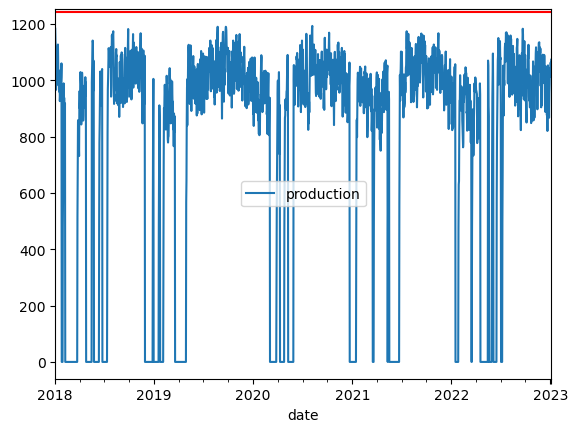

In [17]:
dfbru1.plot("date","production")
plt.axhline(dicmsr["BRU msr"], color = 'r')